# Original

Thank you Josh!

https://www.kaggle.com/code/joshuaswords/netflix-data-visualization/notebook

# Data Visualization

The purpose of this notebook is to practice data visualization, and hopefully communicate some best-practices along the way.

In [1]:
# Standard Imports
import os
import random
import warnings
import datetime as dt
from datetime import datetime

# Data Manipulation and Analysis
import numpy as np
import pandas as pd

# Preprocessing and Clustering
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
from sklearn.cluster import KMeans, AffinityPropagation

# Visualization
import matplotlib.colors
import matplotlib.pyplot as plt
import matplotlib.lines as lines
import seaborn as sns
import missingno as msno

# Plotly for Interactive Plots
import plotly as py
import plotly.graph_objs as go
py.offline.init_notebook_mode(connected=True)

# Matplotlib configuration
plt.rcParams['figure.dpi'] = 140

# WorldCloud
from wordcloud import WordCloud
from PIL import Image

# IPython Magic Commands
%matplotlib inline
%reload_ext autotime

# Suppress Warnings
warnings.filterwarnings('ignore')

time: 16 ms (started: 2024-07-12 18:50:02 +09:00)


In [2]:
df = pd.read_csv('./netflix_titles.csv')

df.head(3)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...


time: 62 ms (started: 2024-07-12 18:50:02 +09:00)


In [3]:
# Missing data
null_rates = df.isna().mean() * 100
null_rates = null_rates[null_rates > 0].round(2)

for column, null_rate in null_rates.items():
    print(f"{column} null rate: {null_rate}%")

director null rate: 29.91%
cast null rate: 9.37%
country null rate: 9.44%
date_added null rate: 0.11%
rating null rate: 0.05%
duration null rate: 0.03%
time: 0 ns (started: 2024-07-12 18:50:02 +09:00)


6 columns have missing values, with Director missing 1/3 of the time

# Dealing with the missing data

This is always scenario dependant, but in this case, I will:
- replace blank countries with the mode (most common) country
- I want to keep director as it could be interesting to look at a certain director's films
- I want to keep cast as it could be interesting to look at a certain cast's films

In [4]:
# Replacements

# Fill missing values for 'country' with the mode
df['country'].fillna(df['country'].mode()[0], inplace=True)

# Replace NaNs in 'cast' and 'director' with 'No Data'
df[['cast', 'director']] = df[['cast', 'director']].fillna('No Data')

# Drop remaining rows with missing values and duplicates
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

time: 31 ms (started: 2024-07-12 18:50:02 +09:00)


In [5]:
df.isnull().sum()

show_id         0
type            0
title           0
director        0
cast            0
country         0
date_added      0
release_year    0
rating          0
duration        0
listed_in       0
description     0
dtype: int64

time: 0 ns (started: 2024-07-12 18:50:02 +09:00)


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8790 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8790 non-null   object
 1   type          8790 non-null   object
 2   title         8790 non-null   object
 3   director      8790 non-null   object
 4   cast          8790 non-null   object
 5   country       8790 non-null   object
 6   date_added    8790 non-null   object
 7   release_year  8790 non-null   int64 
 8   rating        8790 non-null   object
 9   duration      8790 non-null   object
 10  listed_in     8790 non-null   object
 11  description   8790 non-null   object
dtypes: int64(1), object(11)
memory usage: 892.7+ KB
time: 16 ms (started: 2024-07-12 18:50:02 +09:00)


# Missing values dealt with, but the date isn't quite right yet...

In [7]:
df['date_added'] = pd.to_datetime(df['date_added'])

df['month_added'] = df['date_added'].dt.month
df['month_name_added'] = df['date_added'].dt.month_name()
df['year_added'] = df['date_added'].dt.year

df.head(3)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,month_added,month_name_added,year_added
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,No Data,United States,2021-09-25,2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm...",9,September,2021
1,s2,TV Show,Blood & Water,No Data,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,2021-09-24,2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t...",9,September,2021
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",United States,2021-09-24,2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...,9,September,2021


time: 110 ms (started: 2024-07-12 18:50:02 +09:00)


# Where possible, I'll use the Netflix brand colurs

https://assetshare.netflixstudios.com/27db6915-a318-48b6-98d1-7ebe4bc499a2

Using a consistent color palette is a great way to give your work credibility. It looks professional, and keeps the reader engaged.

It's an easy-to-implement tip that really helps.

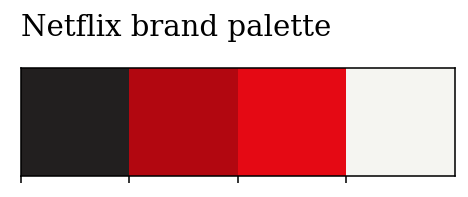

time: 62 ms (started: 2024-07-12 18:50:02 +09:00)


In [8]:
# Palette
sns.palplot(['#221f1f', '#b20710', '#e50914', '#f5f5f1'])

plt.title("Netflix brand palette ", loc='left', fontfamily='serif', fontsize=15, y=1.2)
plt.show()

# Netflix through the years

Netflix started as DVD rentals, and now they have an audience of over 150m people - this is their story...

Timeline code from Subin An's awesome notebook https://www.kaggle.com/code/subinium/awesome-visualization-with-titanic-dataset

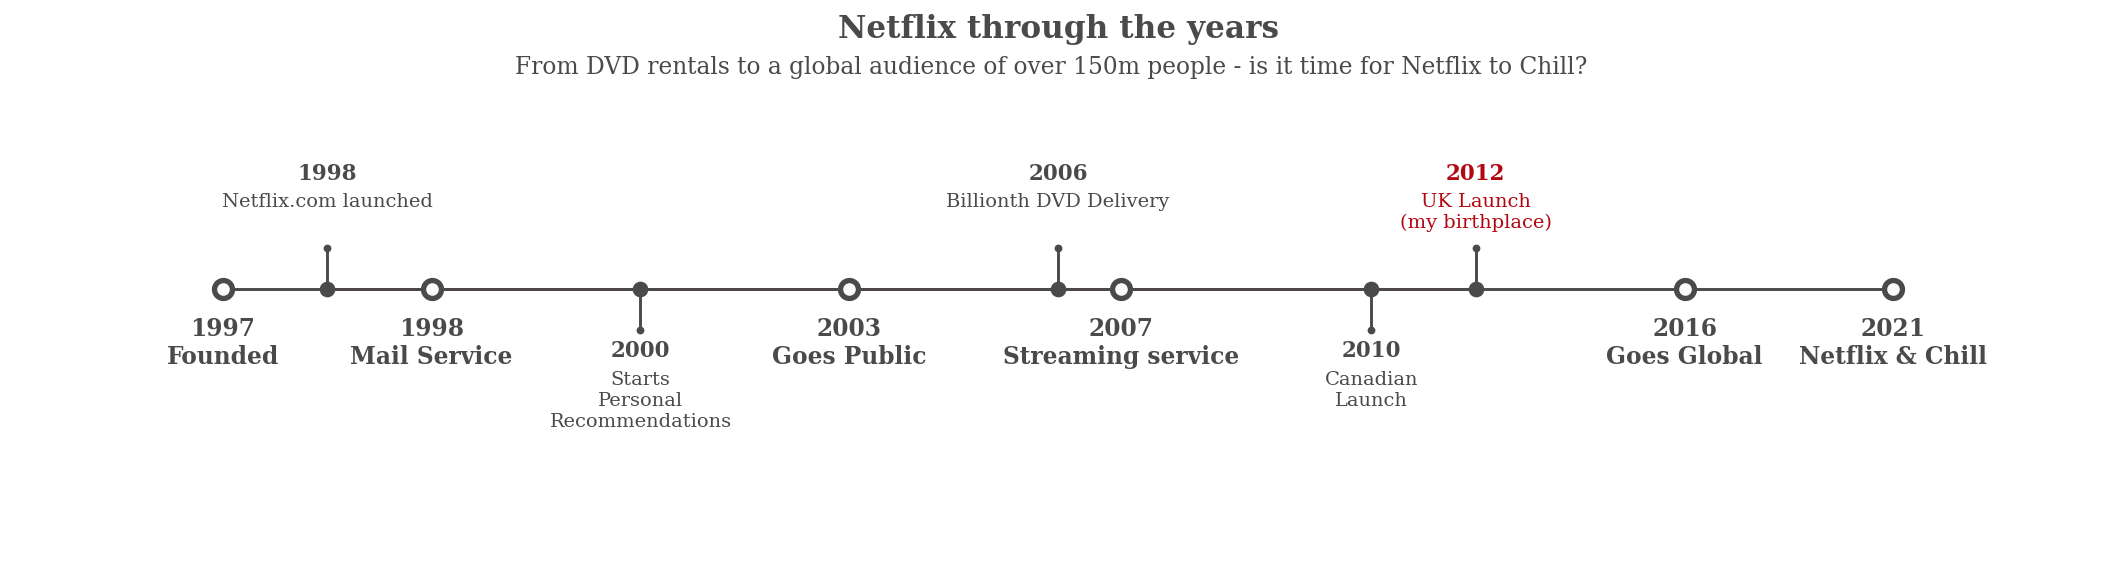

time: 140 ms (started: 2024-07-12 18:50:02 +09:00)


In [9]:
# these go on the numbers below
tl_dates = [
    "1997\nFounded",
    "1998\nMail Service",
    "2003\nGoes Public",
    "2007\nStreaming service",
    "2016\nGoes Global",
    "2021\nNetflix & Chill"
]

tl_x = [1, 2, 4, 5.3, 8, 9]

# these go on the numbers
tl_sub_x = [1.5, 3, 5, 6.5, 7]

tl_sub_times = [
    "1998", "2000", "2006", "2010", "2012"
]

tl_text = [
    "Netflix.com launched",
    "Starts\nPersonal\nRecommendations", "Billionth DVD Delivery", "Canadian\nLaunch", "UK Launch\n(my birthplace)"]

# Set figure & Axes
fig, ax = plt.subplots(figsize=(15, 4), constrained_layout=True)
ax.set_ylim(-2, 1.75)
ax.set_xlim(0, 10)

# Timeline: line
ax.axhline(0, xmin=0.1, xmax=0.9, c='#4a4a4a', zorder=1)

# Timeline: Date Points
ax.scatter(tl_x, np.zeros(len(tl_x)), s=120, c='#4a4a4a', zorder=2)
ax.scatter(tl_x, np.zeros(len(tl_x)), s=30, c='#fafafa', zorder=3)
# Timeline: Time Points
ax.scatter(tl_sub_x, np.zeros(len(tl_sub_x)), s=50, c='#4a4a4a', zorder=4)

# Date Text
for x, date in zip(tl_x, tl_dates):
    ax.text(x, -0.55, date, ha='center',
            fontfamily='serif', fontweight='bold',
            color='#4a4a4a', fontsize=12)

# Stemplot: vertical line
levels = np.zeros(len(tl_sub_x))
levels[::2] = 0.3
levels[1::2] = -0.3
markerline, stemline, baseline = ax.stem(tl_sub_x, levels, use_line_collection=True)
plt.setp(baseline, zorder=0)
plt.setp(markerline, marker='.', color='#4a4a4a')
plt.setp(stemline, color='#4a4a4a')

# Text
for idx, x, time, txt in zip(range(1, len(tl_sub_x) + 1), tl_sub_x, tl_sub_times, tl_text):
    ax.text(x, 1.3*(idx%2)-0.5, time, ha='center',
            fontfamily='serif', fontweight='bold',
            color='#4a4a4a' if idx!=len(tl_sub_x) else '#b20710', fontsize=11)

    ax.text(x, 1.3*(idx%2)-0.6, txt, va='top', ha='center',
            fontfamily='serif', color='#4a4a4a' if idx!=len(tl_sub_x) else '#b20710')
    
# Spine
for spine in ["left", "top", "right", "bottom"]:
    ax.spines[spine].set_visible(False)

# Ticks
ax.set_xticks([])
ax.set_yticks([])

# Title
ax.set_title("Netflix through the years", fontweight='bold', fontfamily='serif', fontsize=16,
             color='#4a4a4a')
ax.text(2.4, 1.57, "From DVD rentals to a global audience of over 150m people - is it time for Netflix to Chill?", 
        fontfamily='serif', fontsize=12, color='#4a4a4a')

plt.show()

# Content - Let's explore

Now we've seen how Netflix came to dominate our TV screens, let's have a look at the content they offer.

In [10]:
# For viz: Ratio of Movies & TV shows

mf_ratio = df['type'].value_counts(normalize=True).round(2).to_frame().T

mf_ratio

,Movie,TV Show
type,0.7,0.3


time: 0 ns (started: 2024-07-12 18:50:03 +09:00)


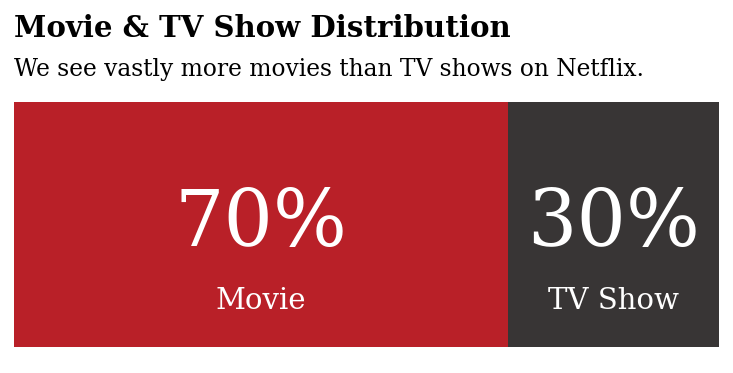

time: 63 ms (started: 2024-07-12 18:50:03 +09:00)


In [11]:
import matplotlib.pyplot as plt

def plot_mf_ratio(mf_ratio):
    """
    Plot the male-female ratio for Movies and TV Shows in a horizontal bar chart.

    Parameters:
    mf_ratio (pd.DataFrame): DataFrame with index and columns 'Movie' and 'TV Show' containing the ratios.
    """
    fig, ax = plt.subplots(figsize=(6.5, 2.5))

    # Plot horizontal bars
    ax.barh(mf_ratio.index, mf_ratio['Movie'], color='#b20710', alpha=0.9, label='Movie')
    ax.barh(mf_ratio.index, mf_ratio['TV Show'], left=mf_ratio['Movie'], color='#221f1f', alpha=0.9, label='TV Show')

    # Set limits and remove ticks
    ax.set_xlim(0, 1)
    ax.set_xticks([])
    ax.set_yticks([])

    # Annotate percentages
    for idx in mf_ratio.index:
        movie_pct = int(mf_ratio.loc[idx, 'Movie'] * 100)
        tv_show_pct = int(mf_ratio.loc[idx, 'TV Show'] * 100)

        # Movie percentage
        ax.annotate(f"{movie_pct}%",
                    xy=(mf_ratio.loc[idx, 'Movie'] / 2, idx),
                    va='center', ha='center', fontsize=40, fontweight='light', family='serif',
                    color='white')
        ax.annotate("Movie",
                    xy=(mf_ratio.loc[idx, 'Movie'] / 2, -0.25),
                    va='center', ha='center', fontsize=15, fontweight='light', fontfamily='serif',
                    color='white')

        # TV Show percentage
        ax.annotate(f"{tv_show_pct}%",
                    xy=(mf_ratio.loc[idx, 'Movie'] + mf_ratio.loc[idx, 'TV Show'] / 2, idx),
                    va='center', ha='center', fontsize=40, fontweight='light', fontfamily='serif',
                    color='white')
        ax.annotate("TV Show",
                    xy=(mf_ratio.loc[idx, 'Movie'] + mf_ratio.loc[idx, 'TV Show'] / 2, -0.25),
                    va='center', ha='center', fontsize=15, fontweight='light', fontfamily='serif',
                    color='white')

    # Title & Subtitle
    fig.text(0.125, 1.03, 'Movie & TV Show Distribution', fontfamily='serif', fontsize=15, fontweight='bold')
    fig.text(0.125, 0.92, 'We see vastly more movies than TV shows on Netflix.', fontfamily='serif', fontsize=12)

    # Remove spines
    for spine in ['top', 'left', 'right', 'bottom']:
        ax.spines[spine].set_visible(False)
    
    # Remove legend due to labelled plot
    ax.legend().set_visible(False)

    plt.show()

plot_mf_ratio(mf_ratio)


# By Country

So we now know there are mush more movies than TV shows on Netflix (which surprises me!).

What about if we look at content by country?

I would imagine that the USA will have the most content. I wonder how my country, the UK, will compare?

In [12]:
# Quick feature engineering

# Helper column for various plots
df['count'] = 1

# Extract the first country listed
df['first_country'] = df['country'].str.split(",").str[0]

# Rating ages dictionary
ratings_ages = {
    'TV-PG': 'Older Kids',
    'TV-MA': 'Adults',
    'TV-Y7-FV': 'Older Kids',
    'TV-Y7': 'Older Kids',
    'TV-14': 'Teens',
    'R': 'Adults',
    'TV-Y': 'Kids',
    'NR': 'Adults',
    'PG-13': 'Teens',
    'TV-G': 'Kids',
    'PG': 'Older Kids',
    'G': 'Kids',
    'UR': 'Adults',
    'NC-17': 'Adults'
}

df['target_ages'] = df['rating'].map(ratings_ages)

# Genre
df['genre'] = df['listed_in'].str.replace(' ,', ',').str.replace(', ', ',').str.split(',')

# Reducing name length
country_replacements = {
    'United States': 'USA',
    'United Kingdom': 'UK',
    'South Korea': 'S. Korea'
}

df['first_country'].replace(country_replacements, inplace=True)

time: 78 ms (started: 2024-07-12 18:50:03 +09:00)


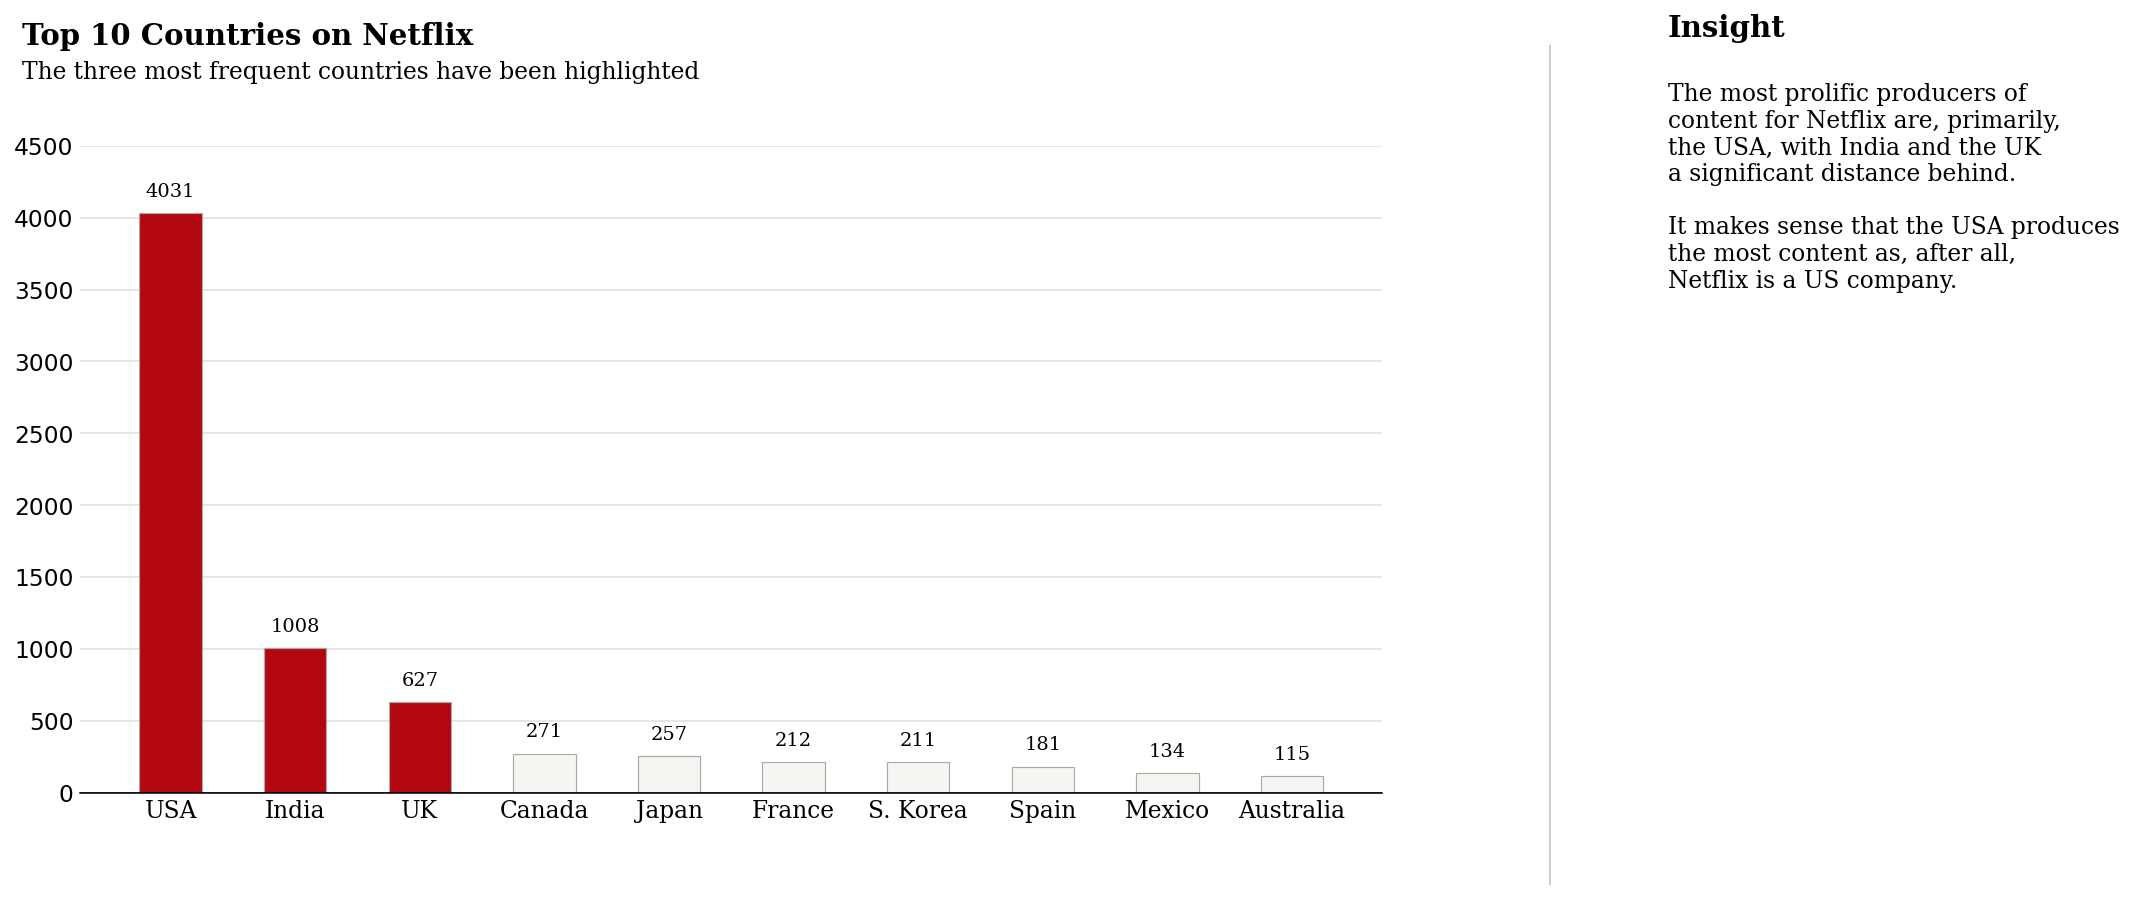

time: 203 ms (started: 2024-07-12 18:50:03 +09:00)


In [13]:
# Get the top 10 countries by count
data = df['first_country'].value_counts().nlargest(10)

# Define color map
color_map = ['#f5f5f1'] * 10
color_map[:3] = ['#b20710'] * 3  # Highlight the top three

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(data.index, data, width=0.5, edgecolor='darkgray', linewidth=0.6, color=color_map)

# Add annotations
for bar in bars:
    height = bar.get_height()
    ax.annotate(f"{height}",
                xy=(bar.get_x() + bar.get_width() / 2, height + 150),
                va='center', ha='center', fontweight='light', fontfamily='serif')

# Remove unnecessary borders
for spine in ['top', 'left', 'right']:
    ax.spines[spine].set_visible(False)

# Set tick labels
ax.set_xticklabels(data.index, fontfamily='serif')

# Add grid lines and customize ticks
ax.grid(axis='y', linestyle='-', alpha=0.4)
ax.set_yticks(np.arange(0, 5000, 500))
ax.set_axisbelow(True)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='both', length=0)

# Add horizontal line at y=0
plt.axhline(y=0, color='black', linewidth=1.3, alpha=.7)

# Add title and subtitles
fig.text(0.09, 1, 'Top 10 Countries on Netflix', fontsize=15, fontweight='bold', fontfamily='serif')
fig.text(0.09, 0.96, 'The three most frequent countries have been highlighted', fontsize=12, fontweight='light', fontfamily='serif')

# Add insight box
fig.text(1.07, 1.01, 'Insight', fontsize=15, fontweight='bold', fontfamily='serif')
fig.text(1.07, 0.68, '''
The most prolific producers of
content for Netflix are, primarily,
the USA, with India and the UK
a significant distance behind.

It makes sense that the USA produces
the most content as, after all,
Netflix is a US company.
''', fontsize=12, fontweight='light', fontfamily='serif')

# Add dividing line
fig.lines.append(plt.Line2D([1, 1], [0, 1], transform=fig.transFigure, color='black', lw=0.2))

plt.show()

As predicted, the USA dominates.

The UK is a top contender too, but still some way behind India.

How does content by country vary?

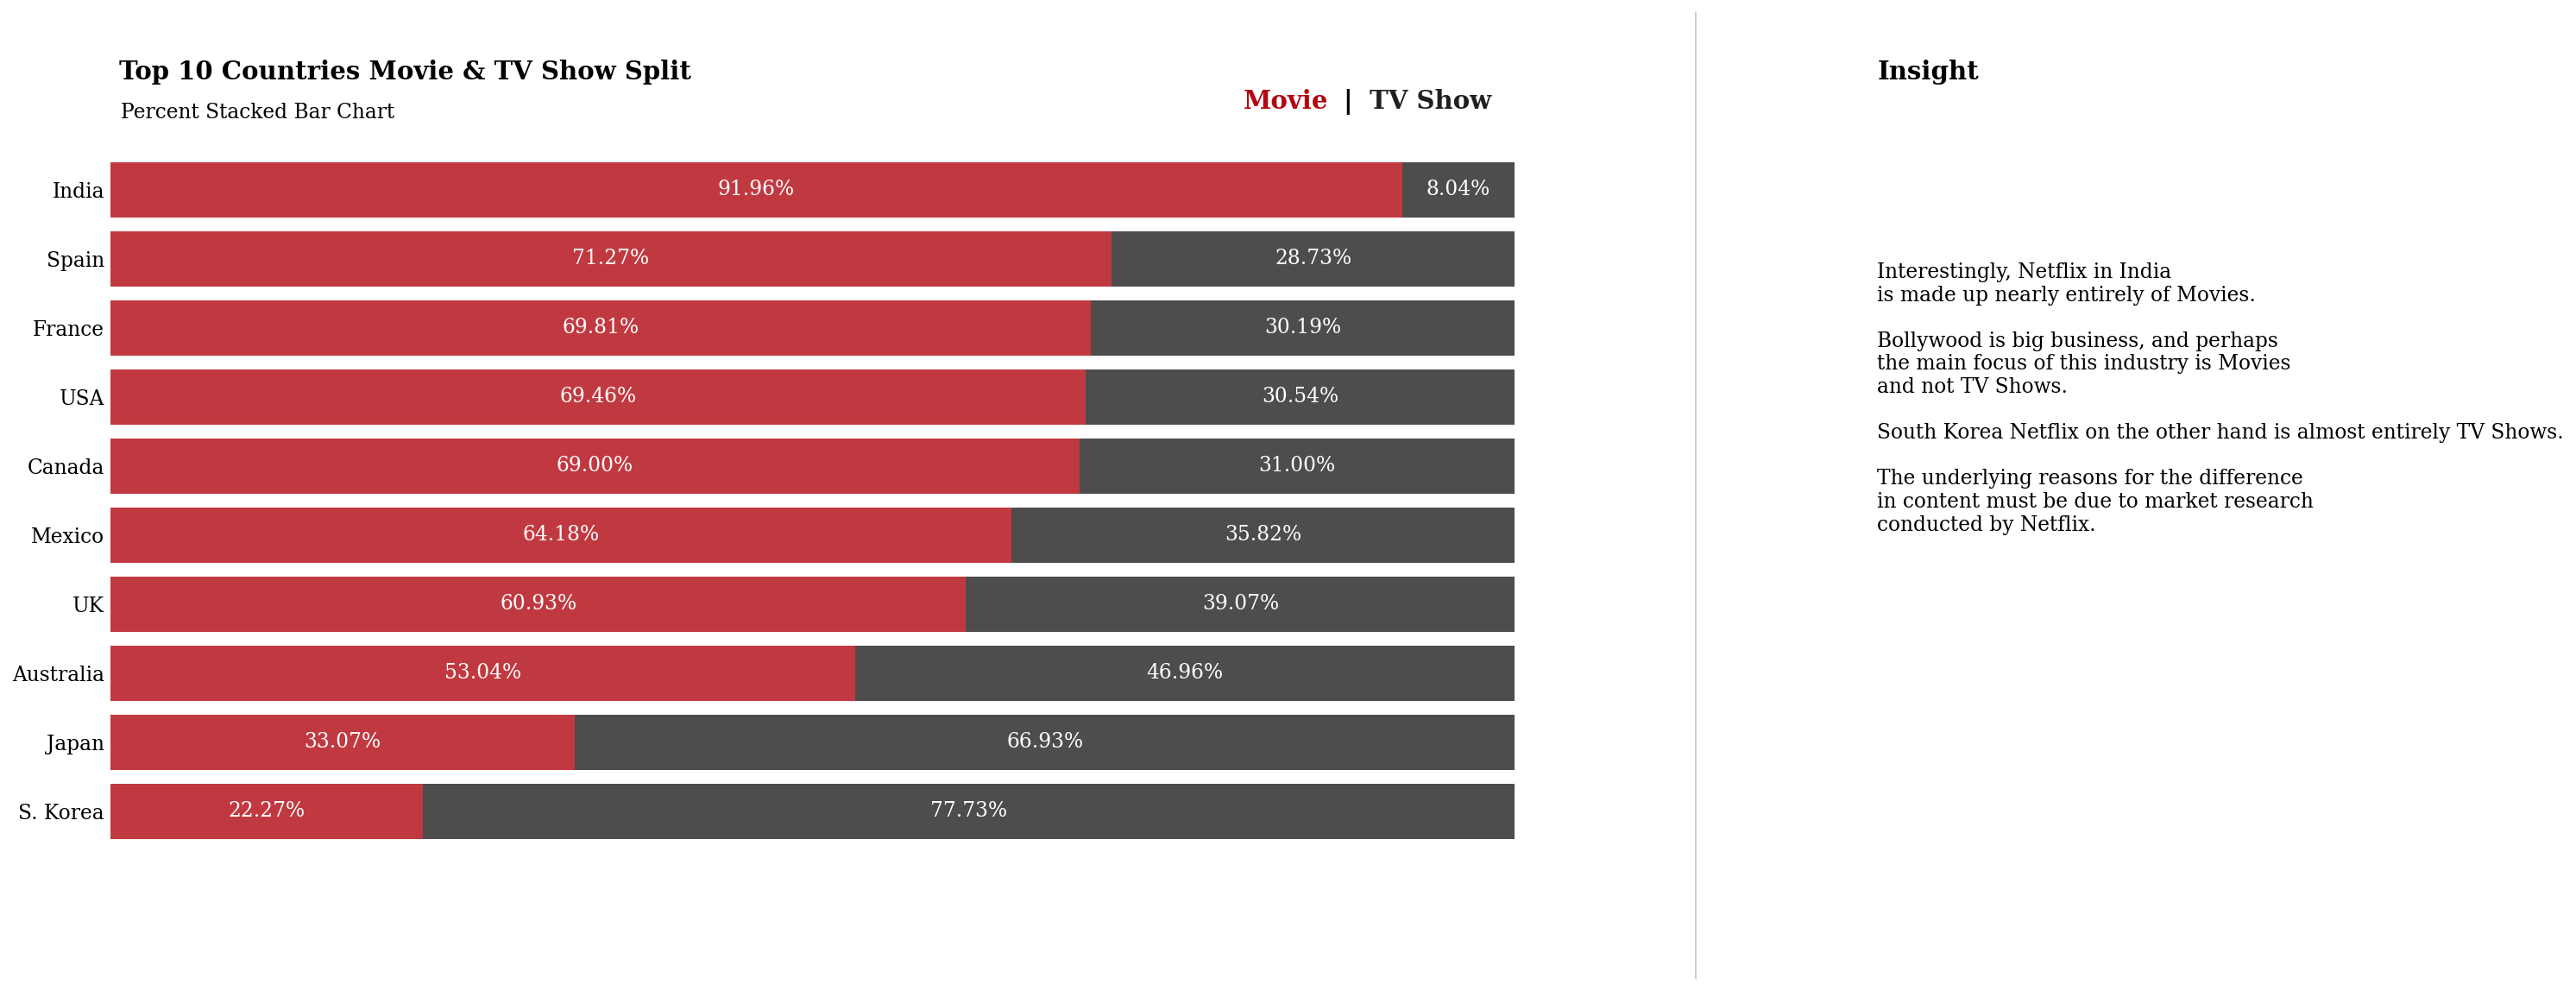

time: 313 ms (started: 2024-07-12 18:50:03 +09:00)


In [14]:
country_order = df['first_country'].value_counts().nlargest(10).index
data_q2q3 = df.pivot_table(values='count', index='first_country', columns='type', aggfunc='size').loc[country_order]
data_q2q3['sum'] = data_q2q3.sum(axis=1)
data_q2q3_ratio = data_q2q3.apply(lambda x: x/x['sum'], axis=1)[['Movie', 'TV Show']].sort_values(by='Movie', ascending=True)

# Create the plot
fig, ax = plt.subplots(figsize=(15, 8))

# Plot horizontal bars
ax.barh(data_q2q3_ratio.index, data_q2q3_ratio['Movie'], color='#b20710', alpha=0.8, label='Movie')
ax.barh(data_q2q3_ratio.index, data_q2q3_ratio['TV Show'], left=data_q2q3_ratio['Movie'], color='#221f1f', alpha=0.8, label='TV Show')

# Customize plot limits and ticks
ax.set_xlim(0, 1)
ax.set_xticks([])
ax.set_yticklabels(data_q2q3_ratio.index, fontfamily='serif', fontsize=11)

# Add annotations for percentage values
for i in data_q2q3_ratio.index:
    movie_pct = data_q2q3_ratio['Movie'][i] * 100
    tv_show_pct = data_q2q3_ratio['TV Show'][i] * 100
    
    ax.annotate(f"{movie_pct:.2f}%", xy=(data_q2q3_ratio['Movie'][i] / 2, i), 
                va='center', ha='center', fontsize=12, fontweight='light', fontfamily='serif', color='white')
    
    ax.annotate(f"{tv_show_pct:.2f}%", xy=(data_q2q3_ratio['Movie'][i] + data_q2q3_ratio['TV Show'][i] / 2, i), 
                va='center', ha='center', fontsize=12, fontweight='light', fontfamily='serif', color='white')

# Add title and subtitle
fig.text(0.13, 0.93, 'Top 10 Countries Movie & TV Show Split', fontsize=15, fontweight='bold', fontfamily='serif')
fig.text(0.131, 0.89, 'Percent Stacked Bar Chart', fontsize=12, fontfamily='serif')

# Remove plot borders
for spine in ['top', 'left', 'right', 'bottom']:
    ax.spines[spine].set_visible(False)

# Add legend manually
fig.text(0.75, 0.9, "Movie", fontweight="bold", fontfamily='serif', fontsize=15, color='#b20710')
fig.text(0.805, 0.9, "|", fontweight="bold", fontfamily='serif', fontsize=15, color='black')
fig.text(0.82, 0.9, "TV Show", fontweight="bold", fontfamily='serif', fontsize=15, color='#221f1f')

# Add insight text
fig.text(1.1, 0.93, 'Insight', fontsize=15, fontweight='bold', fontfamily='serif')
fig.text(1.1, 0.44, '''
Interestingly, Netflix in India
is made up nearly entirely of Movies.

Bollywood is big business, and perhaps
the main focus of this industry is Movies
and not TV Shows.

South Korea Netflix on the other hand is almost entirely TV Shows.

The underlying reasons for the difference
in content must be due to market research
conducted by Netflix.
''', fontsize=12, fontweight='light', fontfamily='serif')

# Add dividing line
fig.lines.append(plt.Line2D([1, 1], [0, 1], transform=fig.transFigure, color='black', lw=0.2))

# Customize ticks
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='both', length=0)

# Show the plot
plt.show()

As I've noted in the insights on the plot, it is really interesting to see how the split of TV Shows and Movies varies by country.

South Korea is dominated by TV Shows - why is this? I am a huge fan of South Korea cinema so I know they have a great movie selection.

Equally, India is dominated by Movies. I think this might be due to Bollywood - comment below if you have any other ideas!

# Ratings

Let's briefly check out how ratings are distributed

In [15]:
order = df['rating'].value_counts().rename_axis('rating').reset_index(name='count')
rating_order = list(order['rating'])

time: 0 ns (started: 2024-07-12 18:50:03 +09:00)


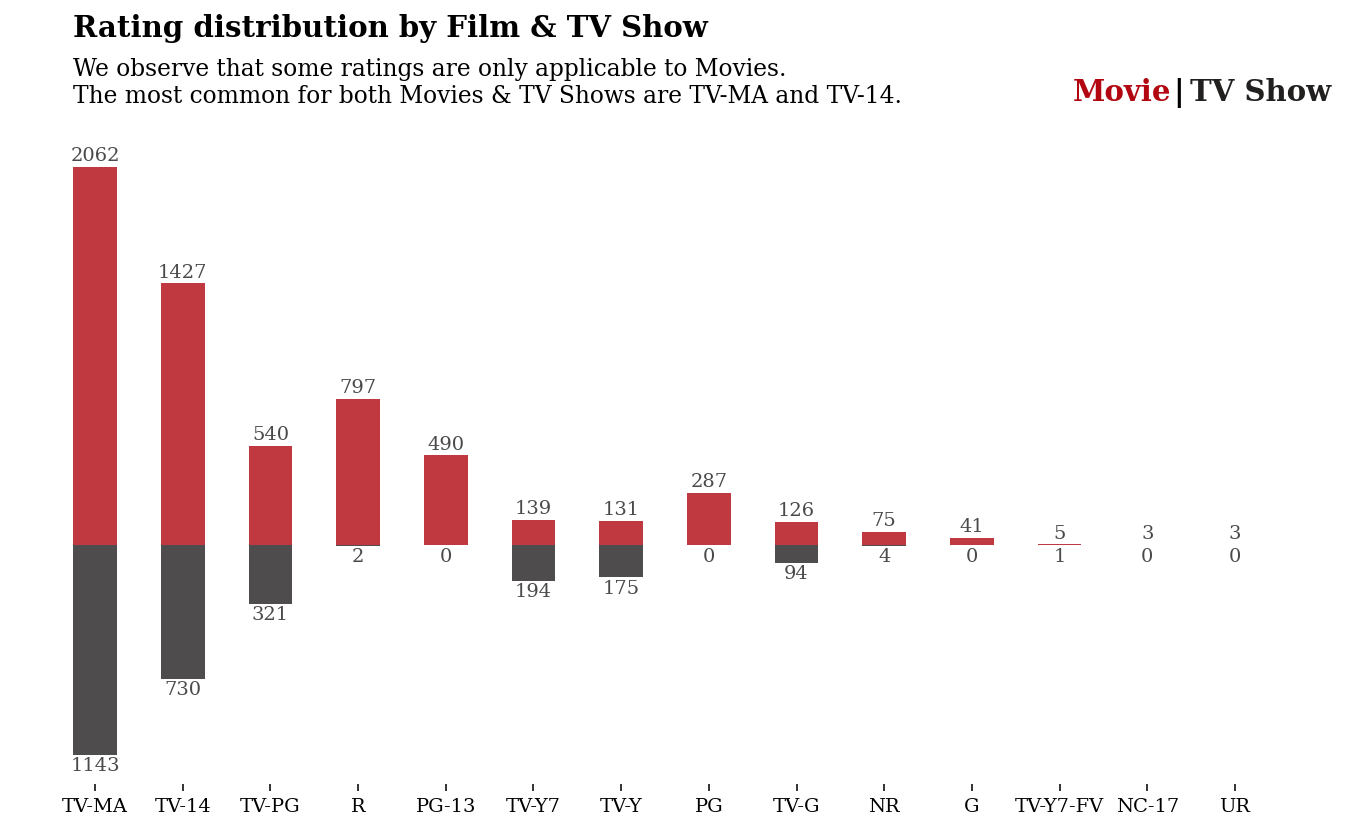

time: 250 ms (started: 2024-07-12 18:50:03 +09:00)


In [16]:
mf = df.pivot_table(index='type', columns='rating', values='count', aggfunc='size').fillna(0).astype(int)[rating_order]

movie = mf.loc['Movie']
tv = -mf.loc['TV Show']

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.bar(movie.index, movie, width=0.5, color='#b20710', alpha=0.8, label='Movie')
ax.bar(tv.index, tv, width=0.5, color='#221f1f', alpha=0.8, label='TV Show')

# Annotations
for i in tv.index:
    ax.annotate(f"{-tv[i]}",
                xy=(i, tv[i] - 60),
                va='center', ha='center', fontweight='light', fontfamily='serif',
                color='#4a4a4a')
    ax.annotate(f"{movie[i]}",
                xy=(i, movie[i] + 60),
                va='center', ha='center', fontweight='light', fontfamily='serif',
                color='#4a4a4a')
    
for spine in ['top', 'left', 'right', 'bottom']:
    ax.spines[spine].set_visible(False)
    
ax.set_xticklabels(mf.columns, fontfamily='serif')
ax.set_yticks([])

ax.legend().set_visible(False)
fig.text(0.16, 1, 'Rating distribution by Film & TV Show', fontsize=15, fontweight='bold', fontfamily='serif')
fig.text(0.16, 0.89,
'''We observe that some ratings are only applicable to Movies.
The most common for both Movies & TV Shows are TV-MA and TV-14.
''', fontsize=12, fontweight='light', fontfamily='serif')

fig.text(0.755, 0.924, "Movie", fontweight="bold", fontfamily='serif', fontsize=15, color='#b20710')
fig.text(0.815, 0.924, "|", fontweight="bold", fontfamily='serif', fontsize=15, color='black')
fig.text(0.825, 0.924, "TV Show", fontweight="bold", fontfamily='serif', fontsize=15, color='#221f1f')

plt.show()

# How has content been added over the years?

As we saw in the timeline at the start of this analysis, Netflix went global in 2016 - and it is extremely noticeable in this plot.

The increase is Movie content is remarkable.

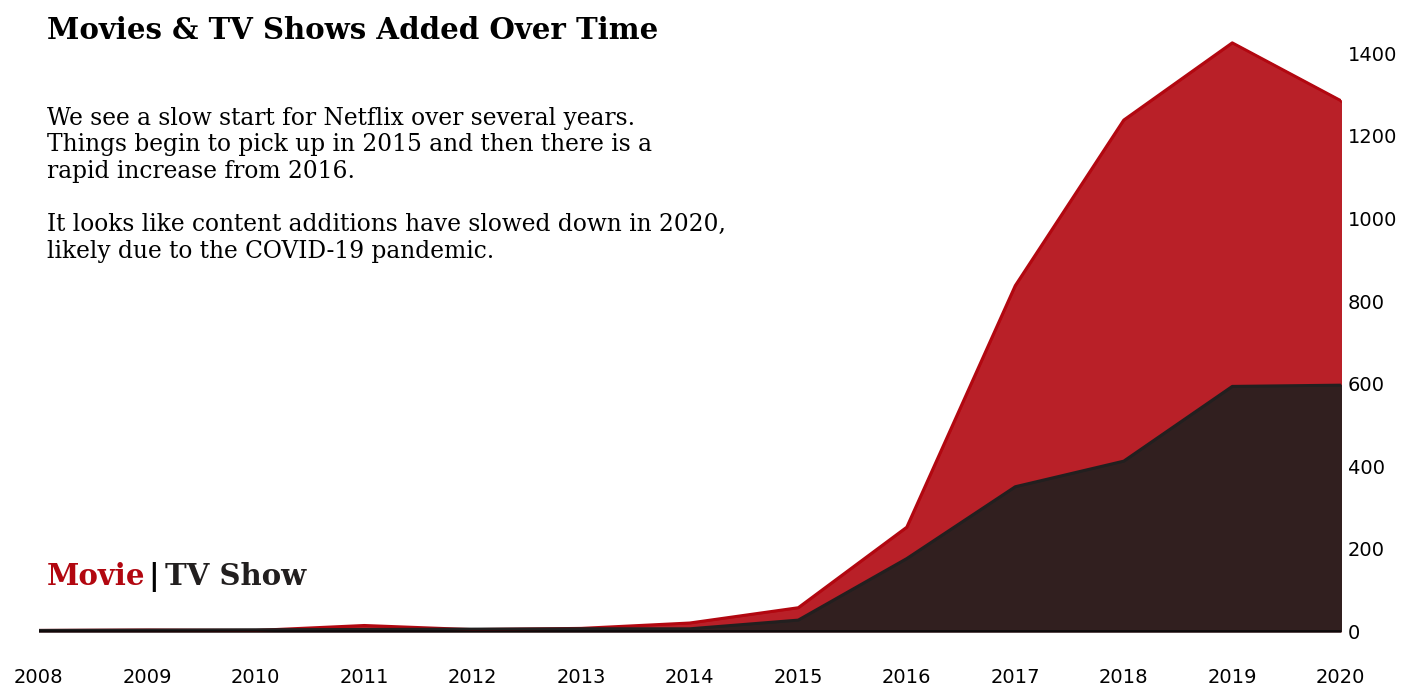

time: 156 ms (started: 2024-07-12 18:50:04 +09:00)


In [17]:
# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))
colors = ['#b20710', '#221f1f']
unique_types = df['type'].unique()

# Plot data
for i, mtv in enumerate(unique_types):
    mtv_rel = df[df['type'] == mtv]['year_added'].value_counts().sort_index()
    ax.plot(mtv_rel.index, mtv_rel, color=colors[i], label=mtv)
    ax.fill_between(mtv_rel.index, mtv_rel, color=colors[i], alpha=0.9)

# Customize the plot
ax.yaxis.tick_right()
ax.axhline(y=0, color='black', linewidth=1.3, alpha=0.7)

# Remove unnecessary spines
for spine in ['top', 'right', 'bottom', 'left']:
    ax.spines[spine].set_visible(False)

# Add grid
ax.grid(False)

# Set x-axis limits and ticks
ax.set_xlim(2008, 2020)
ax.set_xticks(np.arange(2008, 2021, 1))

# Add title and annotations
fig.text(0.13, 0.85, 'Movies & TV Shows Added Over Time', fontsize=15, fontweight='bold', fontfamily='serif')
fig.text(0.13, 0.59, 
'''We see a slow start for Netflix over several years.
Things begin to pick up in 2015 and then there is a
rapid increase from 2016.

It looks like content additions have slowed down in 2020,
likely due to the COVID-19 pandemic.''', 
fontsize=12, fontweight='light', fontfamily='serif')

# Add custom legend
fig.text(0.13, 0.2, "Movie", fontweight="bold", fontfamily='serif', fontsize=15, color='#b20710')
fig.text(0.19, 0.2, "|", fontweight="bold", fontfamily='serif', fontsize=15, color='black')
fig.text(0.2, 0.2, "TV Show", fontweight="bold", fontfamily='serif', fontsize=15, color='#221f1f')

# Customize tick parameters
ax.tick_params(axis='both', which='both', length=0)

# Show the plot
plt.show()

# We can view the same plot, but as a cumulative total

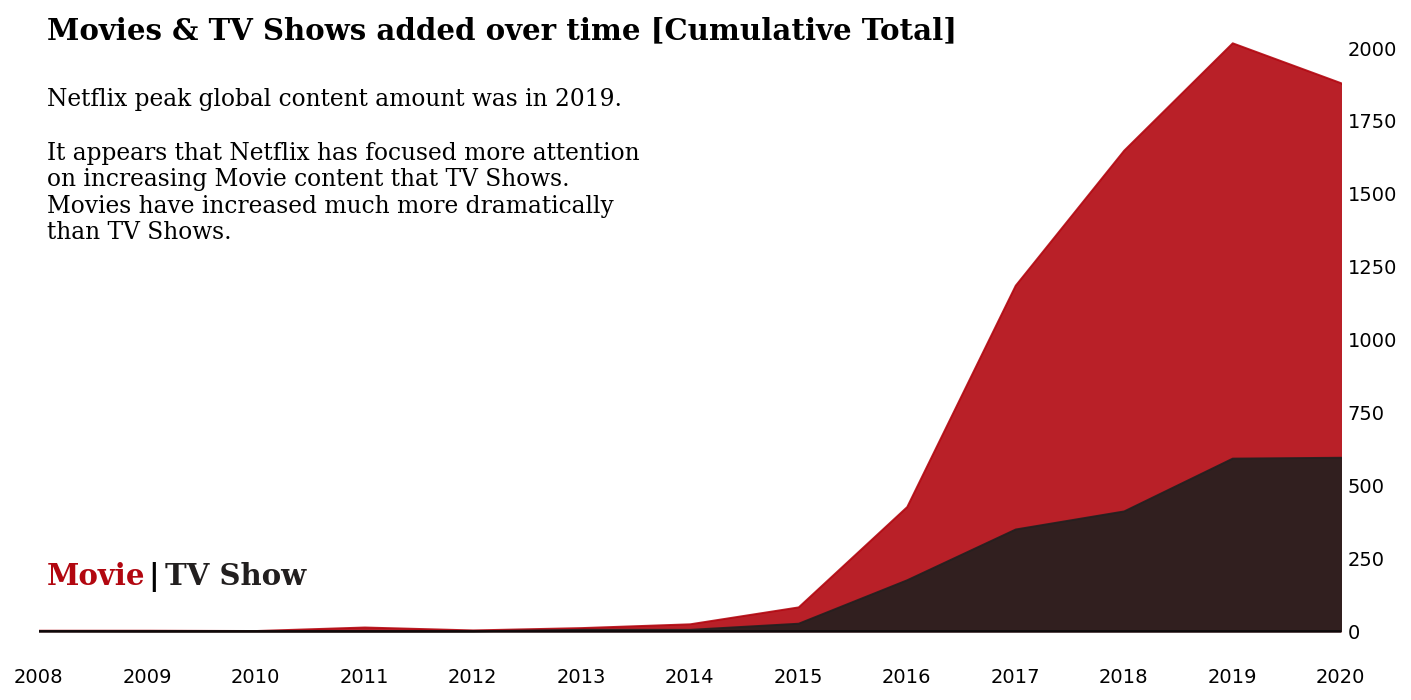

time: 141 ms (started: 2024-07-12 18:50:04 +09:00)


In [18]:
data_sub = df.pivot_table(index='year_added', columns='type', aggfunc='size').fillna(0)[['TV Show', 'Movie']].cumsum(axis=1)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
color = ['#b20710', '#221f1f']
unique_types = df['type'].unique()

for i, mtv in enumerate(unique_types):
    mtv_rel = data_sub[mtv]
    ax.fill_between(mtv_rel.index, 0, mtv_rel, color=color[i], label=mtv, alpha=0.9)
    
ax.yaxis.tick_right()

ax.axhline(y=0, color='black', linewidth=1.3, alpha=0.7)

for spine in ['top', 'left', 'right', 'bottom']:
    ax.spines[spine].set_visible(False)
    
ax.grid(False)

ax.set_xlim(2008, 2020)
plt.xticks(np.arange(2008, 2021, 1))

fig.text(0.13, 0.85, 'Movies & TV Shows added over time [Cumulative Total]', fontsize=15, fontweight='bold', fontfamily='serif')
fig.text(0.13, 0.58,
'''Netflix peak global content amount was in 2019.

It appears that Netflix has focused more attention
on increasing Movie content that TV Shows.
Movies have increased much more dramatically
than TV Shows.
''', fontsize=12, fontweight='light', fontfamily='serif')

fig.text(0.13, 0.2, "Movie", fontweight="bold", fontfamily='serif', fontsize=15, color='#b20710')
fig.text(0.19, 0.2, "|", fontweight="bold", fontfamily='serif', fontsize=15, color='black')
fig.text(0.2, 0.2, "TV Show", fontweight="bold", fontfamily='serif', fontsize=15, color='#221f1f')

ax.tick_params(axis=u'both', which=u'both', length=0)

plt.show()

# Month-by-Month

We've seen how content has increased over the years, but are there certain months that, on average, tend to enjoy more content being added?

I'll show this in a couple of ways - a cumulative year view, and also as a radial plot.

In [19]:
month_order = ['January', 'February', 'March',
               'April', 'May', 'June', 'July', 
               'August', 'September', 'October',
               'November', 'December'
            ]

df['month_name_added'] = pd.Categorical(df['month_name_added'], categories=month_order, ordered=True)

time: 0 ns (started: 2024-07-12 18:50:04 +09:00)


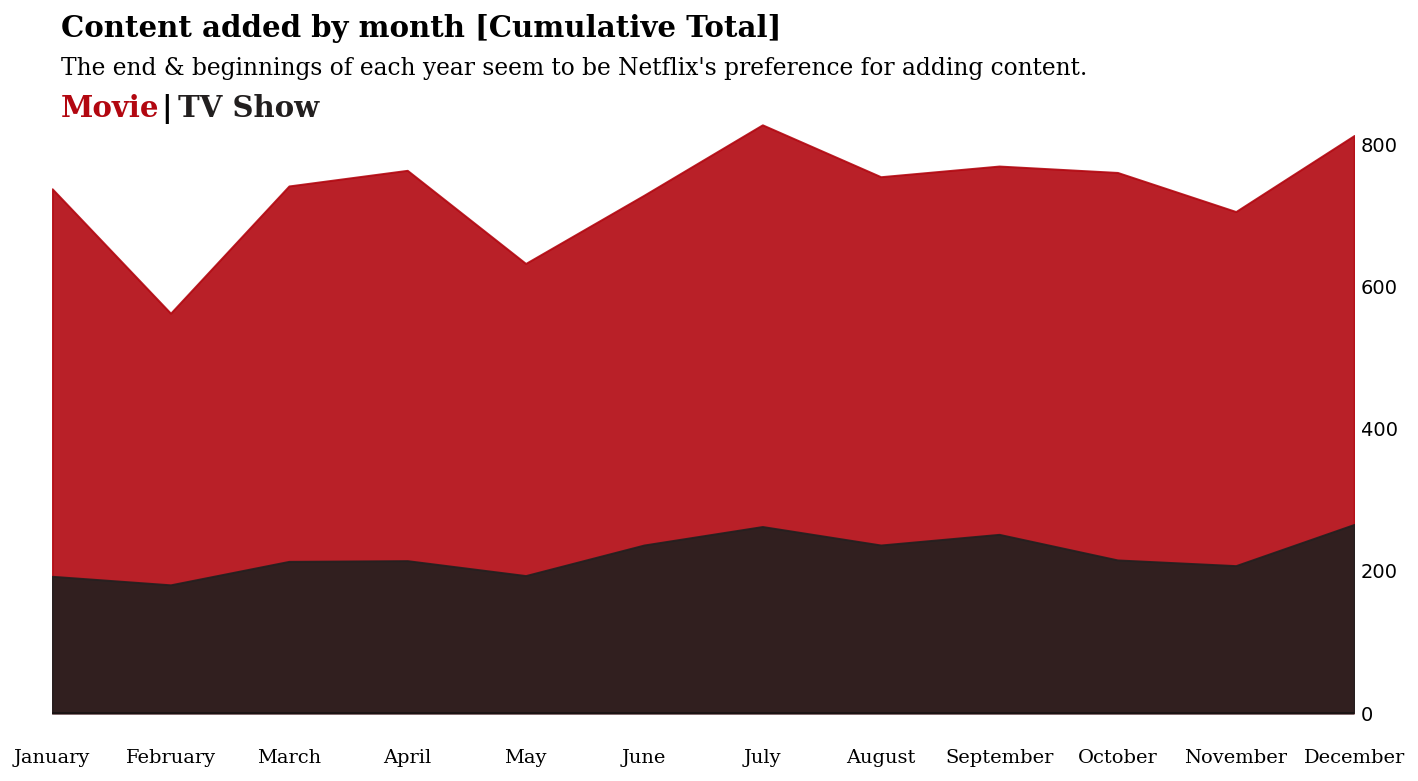

time: 141 ms (started: 2024-07-12 18:50:04 +09:00)


In [20]:
data_sub = df.pivot_table(index='month_name_added', columns='type', aggfunc='size', fill_value=0)[['TV Show', 'Movie']].cumsum(axis=1)

fig, ax = plt.subplots(figsize=(12, 6))
color = ['#b20710', '#221f1f']
unique_types = df['type'].unique()

for i, mtv in enumerate(unique_types):
    mtv_rel = data_sub[mtv]
    ax.fill_between(mtv_rel.index, 0, mtv_rel, color=color[i], label=mtv, alpha=0.9)
    
ax.yaxis.tick_right()
ax.axhline(y=0, color='black', linewidth=1.3, alpha=0.4)

for spine in ['top', 'left', 'right', 'bottom']:
    ax.spines[spine].set_visible(False)
    

ax.set_xticklabels(data_sub.index, fontfamily='serif', rotation=0)
ax.margins(x=0) # remove white spaces next to margins

fig.text(0.13, 0.95, 'Content added by month [Cumulative Total]', fontsize=15, fontweight='bold', fontfamily='serif')
fig.text(0.13, 0.905, "The end & beginnings of each year seem to be Netflix's preference for adding content.", 
        fontsize=12, fontweight='light', fontfamily='serif')

fig.text(0.13, 0.855, "Movie", fontweight="bold", fontfamily='serif', fontsize=15, color='#b20710')
fig.text(0.19, 0.855, "|", fontweight="bold", fontfamily='serif', fontsize=15, color='black')
fig.text(0.2, 0.855, "TV Show", fontweight="bold", fontfamily='serif', fontsize=15, color='#221f1f')

ax.tick_params(axis='both', which='both', length=0)

plt.show()

# What about a more interesting way to view how content is added across the year?

Sometimes visualizations should be eye-catching & attention grabbinb - I think this visual acheives that, even if it isn't the most precise.

By highlighting certain months, the reader's eye is drawn exactly where we want it.

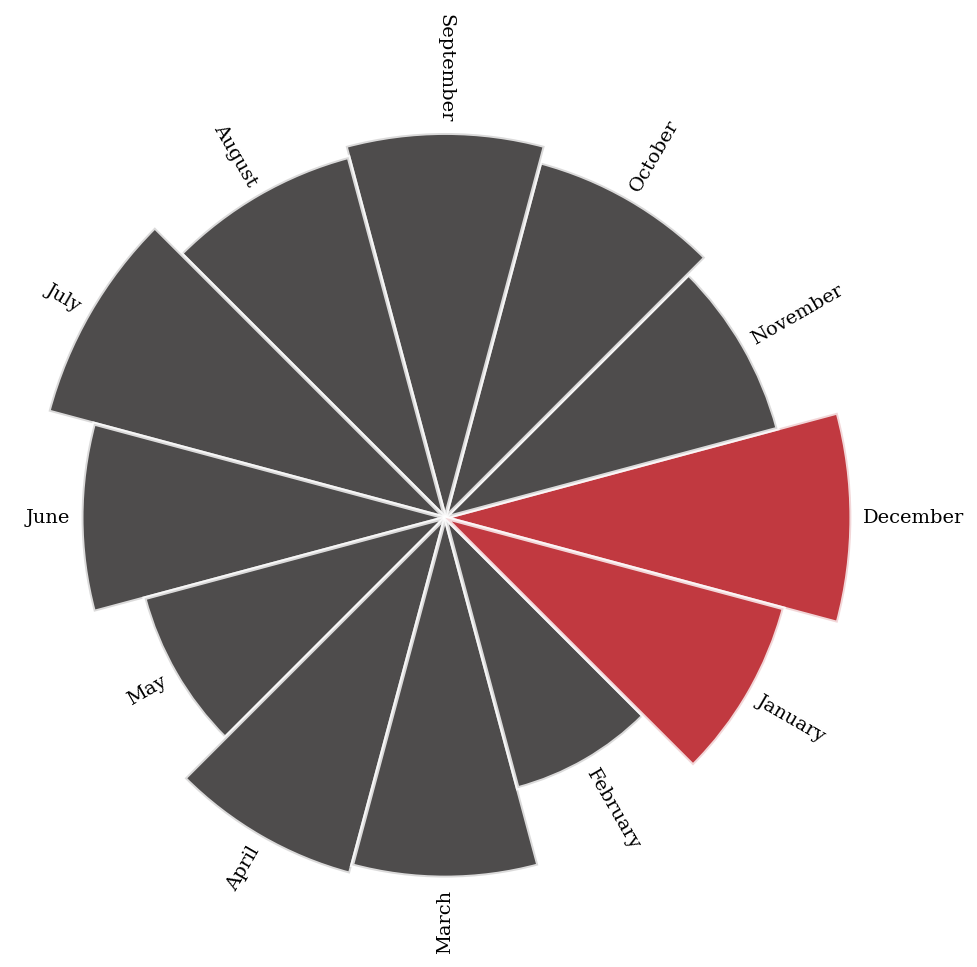

time: 375 ms (started: 2024-07-12 18:50:04 +09:00)


In [21]:
# Prepare the data
data_sub2 = data_sub.copy()
data_sub2['Value'] = data_sub2['Movie'] + data_sub2['TV Show']
df_polar = data_sub2.reset_index().sort_values(by='month_name_added', ascending=False)

# Color map for highlighting
color_map = ['#221f1f'] * 12
color_map[0] = color_map[11] = '#b20710'

# Initialize the figure
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
plt.axis('off')

# Constants for plot layout
upperLimit = 30
lowerLimit = 1
labelPadding = 30

# Compute max and heights
max_value = df_polar['Value'].max()

# Let's compute heights: they are a conversion of each item value in those new coordinates
# In our example, 0 in the dataset will be converted to the lowerLimit (10)
# The maximum will be converted to the upperLimit (100)
slope = (max_value - lowerLimit) / max_value
heights = slope * df_polar['Value'] + lowerLimit

# Compute the width of each bar. In total we have 2*Pi = 360
width = 2 * np.pi / len(df_polar)
angles = np.linspace(0, 2 * np.pi, len(df_polar), endpoint=False)

# Draw bars
bars = ax.bar(
    x=angles,
    height=heights,
    width=width,
    bottom=lowerLimit,
    linewidth=2,
    edgecolor="white",
    color=color_map,
    alpha=0.8
)

# Add labels
for bar, angle, height, label in zip(bars, angles, heights, df_polar["month_name_added"]):
    
    # Labels are rotated. Rotation must be specified in degrees
    rotation = np.rad2deg(angle)
    
    # Flip some labels upside down
    alignment = "left" if angle < np.pi/2 or angle > 3*np.pi/2 else "right"
    rotation = rotation + 180 if alignment == "right" else rotation
        
    # Finally add the labels
    ax.text(
        x=angle,
        y=lowerLimit + height + labelPadding,
        s=label,
        ha=alignment, fontsize=10, fontfamily='serif',
        va='center',
        rotation=rotation,
        rotation_mode="anchor"
    )

plt.show()

Yes, December & January are definitely the best months for new content. Maybe Netflix knows that people have a lot of time off from work over this period and that it is a good time to reel people in?

February is the worst - why might this be? Ideas wlcomed!

# Movie Genres

Let's now explore movie genres a little.

In [22]:
# Custom color map based on Netflix palette
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ['#221f1f', '#b20710', '#f5f5f1'])

def genre_heatmap(df: pd.DataFrame, title: str):
    # Process genres
    df['genre'] = df['listed_in'].str.replace(' ,', ',').str.replace(', ', ',').str.split(',')
    
    # Get unique genres
    unique_genres = set(genre for genres in df['genre'] for genre in genres)
    print(f"There are {len(unique_genres)} types in the Netflix {title} Dataset")
    
    # Binarize the genre data
    mlb = MultiLabelBinarizer()
    genre_binarized = pd.DataFrame(mlb.fit_transform(df['genre']), columns=mlb.classes_, index=df.index)
    
    # Compute the correlation matrix
    corr = genre_binarized.corr()
    
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))
    
    # Plot the heatmap
    fig, ax = plt.subplots(figsize=(10, 7))
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=0.3, vmin=-0.3, center=0, square=True, linewidths=2.5, ax=ax)
    
    # Add titles and annotations
    fig.text(0.54, 0.88, 'Genre Correlation', fontfamily='serif', fontweight='bold', fontsize=15, ha='center')
    fig.text(0.75, 0.665, 
             '''
             It is interesting that Independent Movies
             tend to be Dramas. 
             
             Another observation is that 
             International Movies are rarely
             in the Children's genre.
             ''', fontfamily='serif', fontsize=12, ha='right')
    
    plt.show()

time: 0 ns (started: 2024-07-12 18:50:04 +09:00)


There are 20 types in the Netflix Movie Dataset


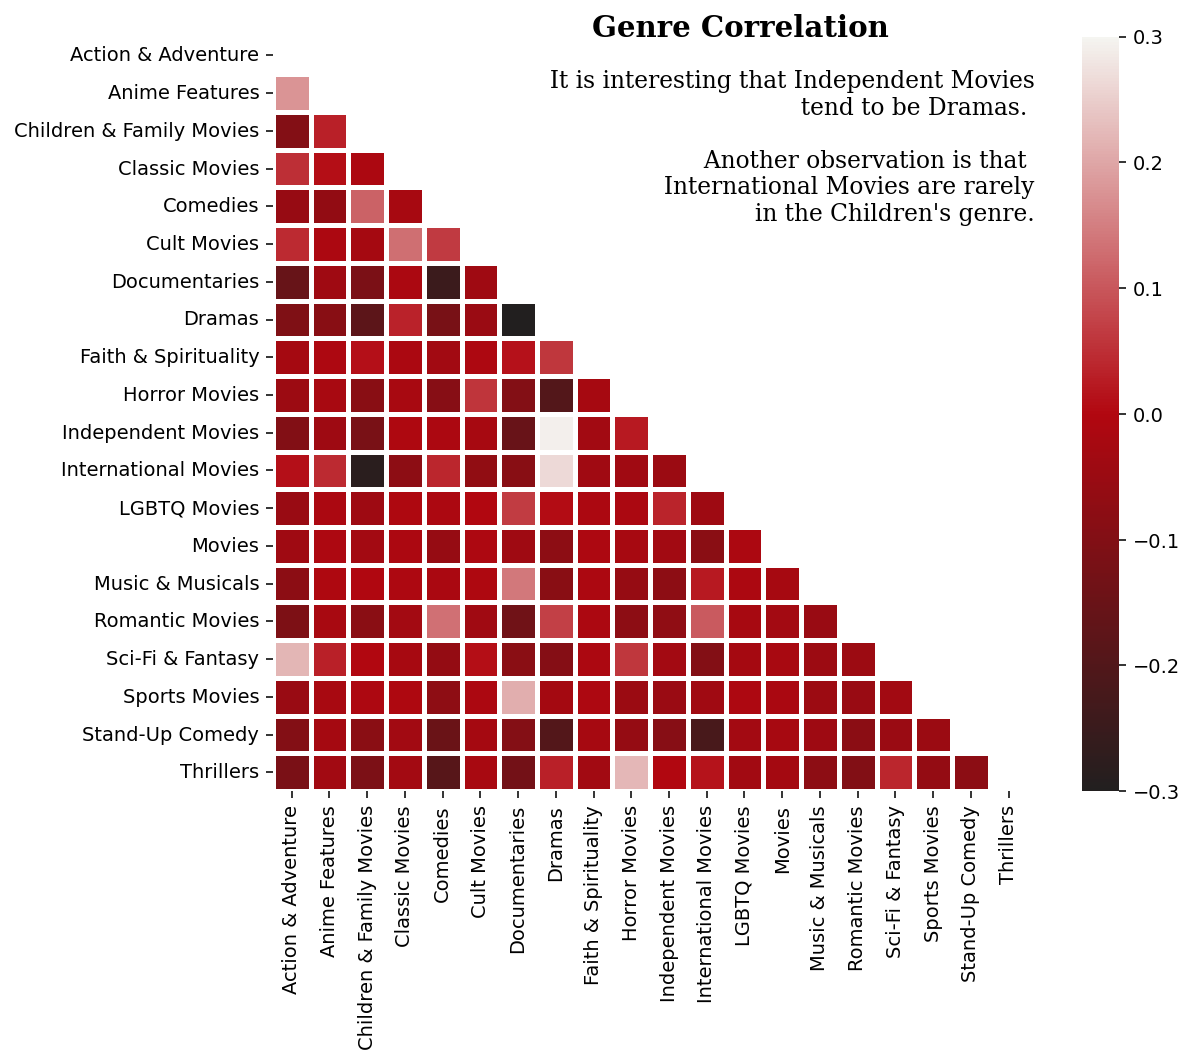

time: 328 ms (started: 2024-07-12 18:50:04 +09:00)


In [23]:
df_tv = df[df["type"] == "TV Show"]
df_movies = df[df["type"] == "Movie"]


genre_heatmap(df_movies, 'Movie')
plt.show()

# Target Ages

Does Netflix uniformly target certain demographics? Or does this vary by country?

In [24]:
top_countries = df['first_country'].value_counts().nlargest(10).index

df_top_countries = df.loc[df['first_country'].isin(top_countries)]

df_heatmap = pd.crosstab(df_top_countries['first_country'], df_top_countries['target_ages'], normalize='index').T

df_heatmap

first_country,Australia,Canada,France,India,Japan,Mexico,S. Korea,Spain,UK,USA
target_ages,,,,,,,,,,
Adults,0.460870,0.476015,0.622642,0.263889,0.354086,0.768657,0.440758,0.817680,0.523126,0.457703
Kids,0.147826,0.143911,0.084906,0.013889,0.011673,0.014925,0.042654,0.033149,0.081340,0.084346
Older Kids,0.234783,0.214022,0.103774,0.158730,0.256809,0.097015,0.118483,0.044199,0.177033,0.200695
Teens,0.156522,0.166052,0.188679,0.563492,0.377432,0.119403,0.398104,0.104972,0.218501,0.257256


time: 16 ms (started: 2024-07-12 18:50:05 +09:00)


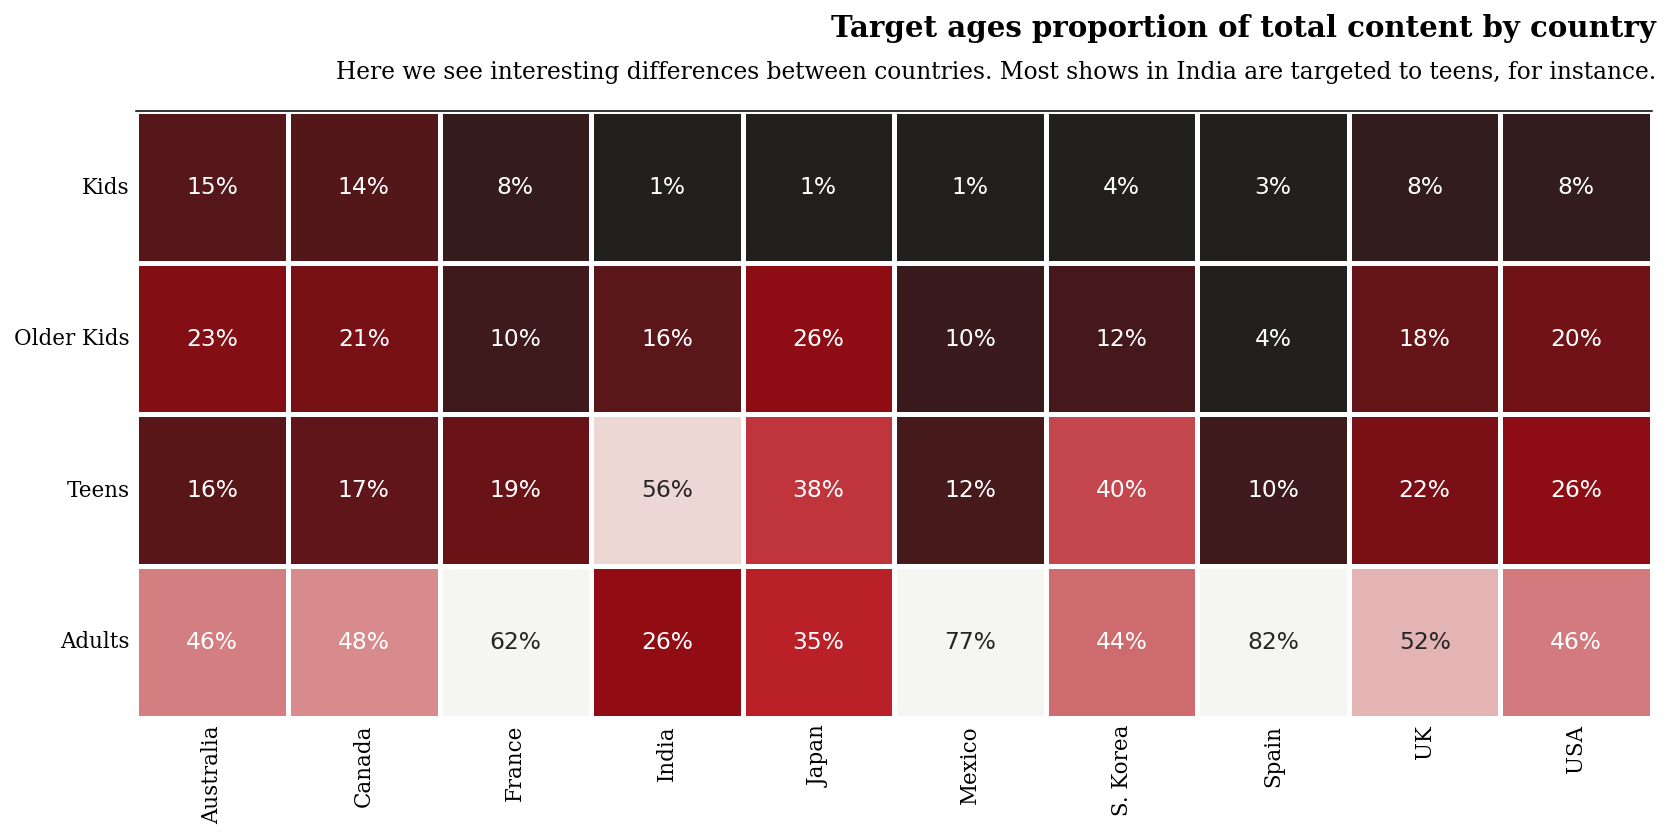

time: 312 ms (started: 2024-07-12 18:50:05 +09:00)


In [25]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

age_order = ['Kids','Older Kids','Teens','Adults']

sns.heatmap(df_heatmap.loc[age_order],cmap=cmap,square=True, linewidth=2.5, cbar=False,
            annot=True, fmt='1.0%', vmax=.6, vmin=0.05, ax=ax, annot_kws={"fontsize":12})

ax.spines['top'].set_visible(True)


fig.text(0.99, 0.725, 'Target ages proportion of total content by country', fontweight='bold', fontfamily='serif', fontsize=15, ha='right')   
fig.text(0.99, 0.7, 'Here we see interesting differences between countries. Most shows in India are targeted to teens, for instance.', ha='right', fontsize=12, fontfamily='serif') 

ax.set_yticklabels(ax.get_yticklabels(), fontfamily='serif', rotation=0, fontsize=11)
ax.set_xticklabels(ax.get_xticklabels(), fontfamily='serif', rotation=90, fontsize=11)

ax.set_ylabel('')    
ax.set_xlabel('')
ax.tick_params(axis='both', which='both', length=0)

plt.tight_layout()
plt.show()

Very interesting results.

It is also interesting to note similarities between culturally similar countries - the US & UK are closely aligned with their Netflix target ages, yet vastly different to say, India or Japan!

# Let's have a quick look at the lag between when content is released and when it is added on Netflix

Spain looks to have a lot of new content. Great for them!

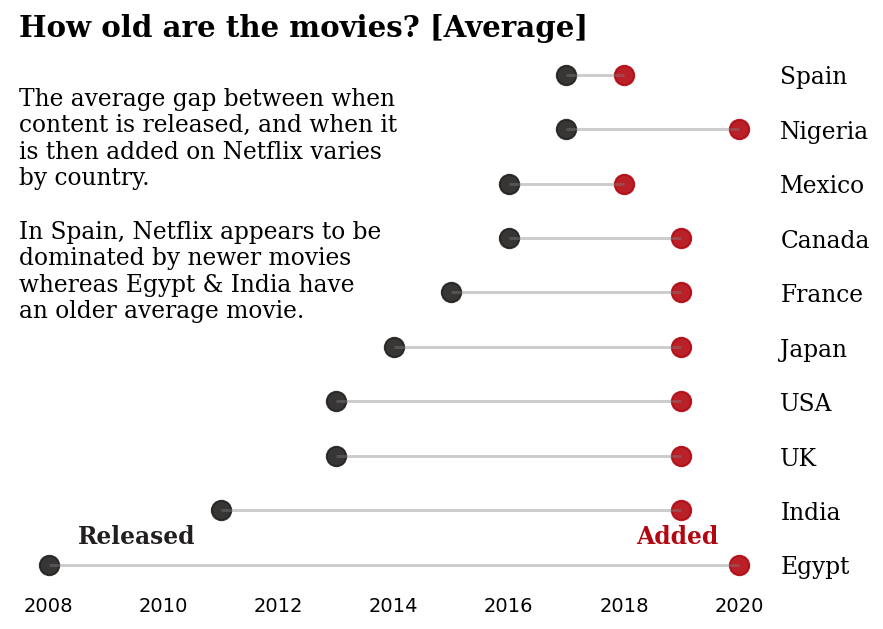

time: 140 ms (started: 2024-07-12 18:50:05 +09:00)


In [26]:
# Get the top 10 countries by count
top10_countries = df_movies['first_country'].value_counts().nlargest(10).index

# Filter the DataFrame for the top 10 countries
df_top10 = df_movies[df_movies['first_country'].isin(top10_countries)]

# Calculate the mean release_year and year_added, rounded to the nearest integer
mean_values = df_top10.groupby('first_country')[['release_year', 'year_added']].mean().round()

# Reorder the DataFrame by release_year
ordered_df = mean_values.sort_values(by='release_year')

# Prepare for plotting
my_range = range(1, len(ordered_df.index) + 1)

# Create the plot
fig, ax = plt.subplots(figsize=(7, 5))
fig.text(0.13, 0.9, 'How old are the movies? [Average]', fontsize=15, fontweight='bold', fontfamily='serif')
plt.hlines(y=my_range, xmin=ordered_df['release_year'], xmax=ordered_df['year_added'], color='grey', alpha=0.4)
plt.scatter(ordered_df['release_year'], my_range, color='#221f1f', s=100, alpha=0.9, label='Average release date')
plt.scatter(ordered_df['year_added'], my_range, color='#b20710', s=100, alpha=0.9, label='Average added date')

# Customize plot appearance
for spine in ['top', 'left', 'right', 'bottom']:
    ax.spines[spine].set_visible(False)
    
ax.tick_params(axis='both', which='both', length=0)
ax.yaxis.tick_right()
plt.yticks(my_range, ordered_df.index, fontname='serif', fontsize=12)

# Add legend and text
fig.text(0.19, 0.175, "Released", fontweight='bold', fontfamily='serif', fontsize=12, color='#221f1f')
fig.text(0.76, 0.175, "Added", fontweight='bold', fontfamily='serif', fontsize=12, color='#b20710')
fig.text(0.13, 0.46, 
'''The average gap between when 
content is released, and when it
is then added on Netflix varies
by country. 

In Spain, Netflix appears to be 
dominated by newer movies 
whereas Egypt & India have
an older average movie.
''', fontsize=12, fontweight='light', fontfamily='serif')

plt.show()

What about TV Shows

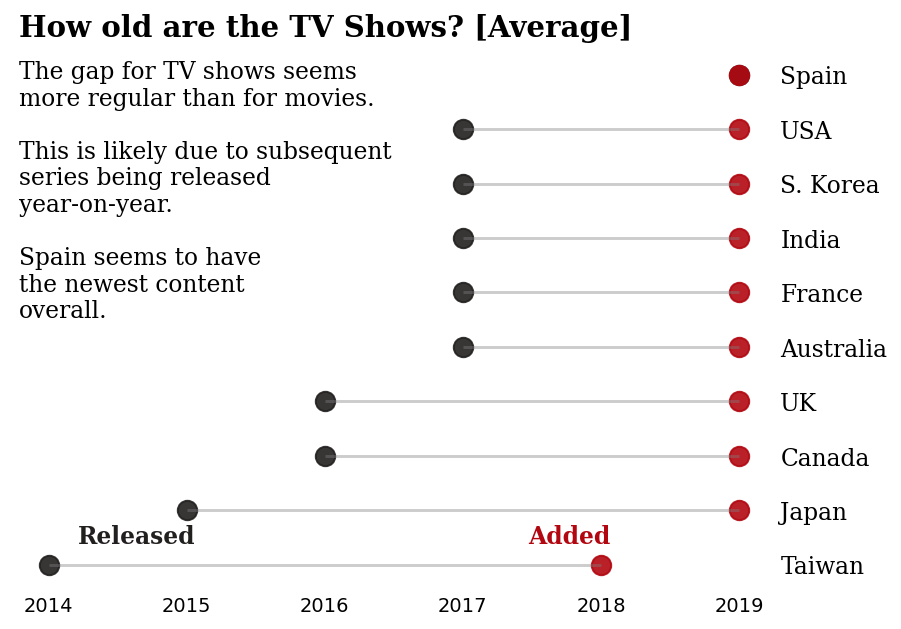

time: 109 ms (started: 2024-07-12 18:50:05 +09:00)


In [27]:
# Get the top 10 countries by count
top10_countries = df_tv['first_country'].value_counts().nlargest(10).index

# Filter the DataFrame for the top 10 countries
df_top10 = df_tv[df_tv['first_country'].isin(top10_countries)]

# Calculate the mean release_year and year_added, rounded to the nearest integer
mean_values = df_top10.groupby('first_country')[['release_year', 'year_added']].mean().round()

# Reorder the DataFrame by release_year
ordered_df = mean_values.sort_values(by='release_year')

# Prepare for plotting
my_range = range(1, len(ordered_df.index) + 1)

# Create the plot
fig, ax = plt.subplots(figsize=(7, 5))
fig.text(0.13, 0.9, 'How old are the TV Shows? [Average]', fontsize=15, fontweight='bold', fontfamily='serif')
plt.hlines(y=my_range, xmin=ordered_df['release_year'], xmax=ordered_df['year_added'], color='grey', alpha=0.4)
plt.scatter(ordered_df['release_year'], my_range, color='#221f1f', s=100, alpha=0.9, label='Average release date')
plt.scatter(ordered_df['year_added'], my_range, color='#b20710', s=100, alpha=0.9, label='Average added date')

# Customize plot appearance
for spine in ['top', 'left', 'right', 'bottom']:
    ax.spines[spine].set_visible(False)
    
ax.tick_params(axis='both', which='both', length=0)
ax.yaxis.tick_right()
plt.yticks(my_range, ordered_df.index, fontname='serif', fontsize=12)

# Add legend and text
fig.text(0.19, 0.175, "Released", fontweight='bold', fontfamily='serif', fontsize=12, color='#221f1f')
fig.text(0.65, 0.175, "Added", fontweight='bold', fontfamily='serif', fontsize=12, color='#b20710')
fig.text(0.13, 0.46, 
'''The gap for TV shows seems
more regular than for movies.

This is likely due to subsequent
series being released
year-on-year.

Spain seems to have
the newest content
overall.
''', fontsize=12, fontweight='light', fontfamily='serif')

plt.show()

# USA & India

As the two largest content countries, it might be fun to compare the two.

In [28]:
us_india = df[df['first_country'].isin(['USA', 'India'])]

data_sub = df.pivot_table(index='year_added', columns='first_country', aggfunc='size', fill_value=0)[['USA', 'India']].cumsum(axis=1)

data_sub

first_country,USA,India
year_added,,
2008,2,2
2009,1,1
2010,1,1
2011,12,12
2012,3,3
2013,10,10
2014,19,19
2015,57,57
2016,196,207


time: 16 ms (started: 2024-07-12 18:50:06 +09:00)


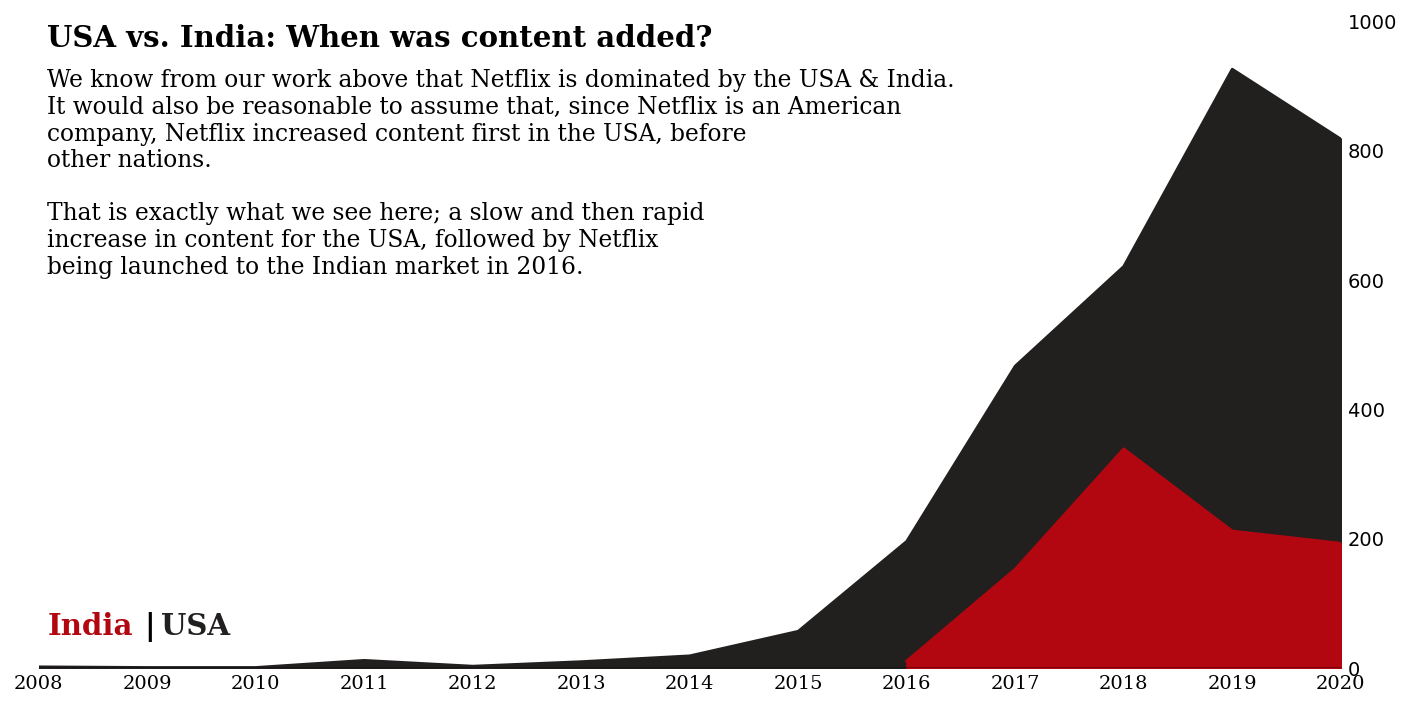

time: 141 ms (started: 2024-07-12 18:50:06 +09:00)


In [29]:
# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))
colors = ['#221f1f', '#b20710', '#f5f5f1']
countries = us_india['first_country'].unique()

# Plot data
for i, country in enumerate(countries):
    content_added = us_india[us_india['first_country'] == country]['year_added'].value_counts().sort_index()
    ax.plot(content_added.index, content_added, color=colors[i], label=country)
    ax.fill_between(content_added.index, 0, content_added, color=colors[i])

# Customize plot appearance
ax.set_ylim(0, 1000)
ax.yaxis.tick_right()
ax.axhline(y=0, color='black', linewidth=1.3, alpha=0.4)

for spine in ['top', 'left', 'right', 'bottom']:
    ax.spines[spine].set_visible(False)

ax.grid(False)
ax.set_xlim(2008, 2020)
ax.set_xticks(np.arange(2008, 2021, 1))
ax.set_xticklabels(ax.get_xticks(), fontfamily='serif', rotation=0)
ax.margins(x=0)  # Remove white spaces next to margins

# Add titles and annotations
fig.text(0.13, 0.85, 'USA vs. India: When was content added?', fontsize=15, fontweight='bold', fontfamily='serif')
fig.text(0.13, 0.58,
         '''
We know from our work above that Netflix is dominated by the USA & India.
It would also be reasonable to assume that, since Netflix is an American
company, Netflix increased content first in the USA, before
other nations.

That is exactly what we see here; a slow and then rapid
increase in content for the USA, followed by Netflix
being launched to the Indian market in 2016.''',
         fontsize=12, fontweight='light', fontfamily='serif')

# Add custom legend
fig.text(0.13, 0.15, "India", fontweight="bold", fontfamily='serif', fontsize=15, color='#b20710')
fig.text(0.188, 0.15, "|", fontweight="bold", fontfamily='serif', fontsize=15, color='black')
fig.text(0.198, 0.15, "USA", fontweight="bold", fontfamily='serif', fontsize=15, color='#221f1f')

# Customize tick parameters
ax.tick_params(axis='both', which='both', length=0)

# Show the plot
plt.show()

In [30]:
data_sub

first_country,USA,India
year_added,,
2008,2,2
2009,1,1
2010,1,1
2011,12,12
2012,3,3
2013,10,10
2014,19,19
2015,57,57
2016,196,207


time: 0 ns (started: 2024-07-12 18:50:06 +09:00)


So the USA dominates. But is there a plot that can convey this in another way?

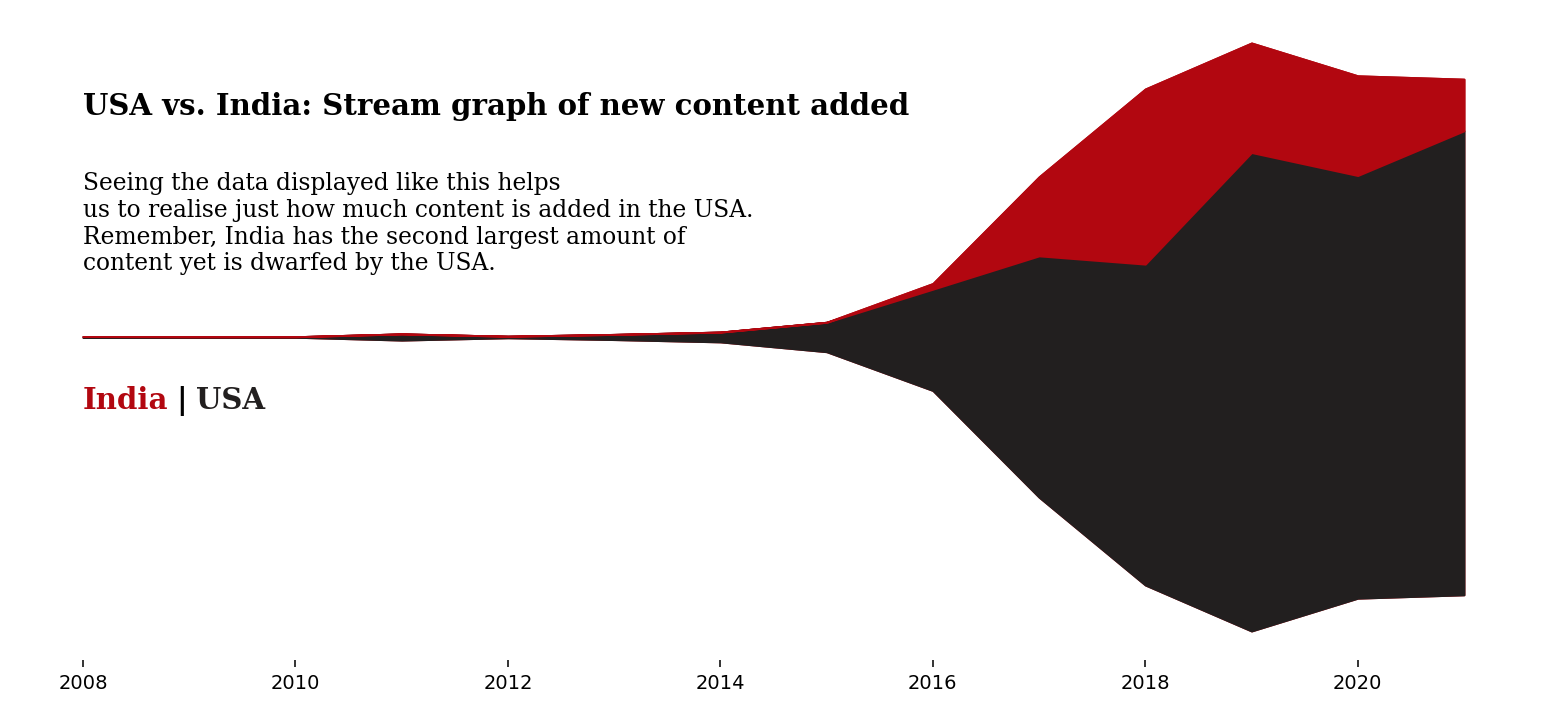

time: 125 ms (started: 2024-07-12 18:50:06 +09:00)


In [31]:
us_ind = df[df['first_country'].isin(['USA', 'India'])]

data_sub = df.groupby('first_country')['year_added'].value_counts().unstack().fillna(0).loc[['USA','India']].cumsum(axis=0).T
data_sub.insert(0, "base", np.zeros(len(data_sub)))

data_sub = data_sub.add(-us_ind['year_added'].value_counts()/2, axis=0)

fig, ax = plt.subplots(1, 1, figsize=(14, 6))
color = ['#221f1f', '#b20710']
hs_list = data_sub.columns
hs_built = data_sub[['India', 'USA']]

for i, hs in enumerate(hs_list, start=0):
    ax.fill_between(data_sub.index, data_sub.iloc[:, i-1], data_sub.iloc[:, i], color=color[i-1])
    
for s in ['top', 'right', 'bottom', 'left']:
    ax.spines[s].set_visible(False)
    
ax.set_axisbelow(True)
ax.set_yticks([])
ax.grid(False)
ax.tick_params(axis=u'y', which=u'both',length=0)

fig.text(0.16, 0.76, 'USA vs. India: Stream graph of new content added', fontsize=15, fontweight='bold', fontfamily='serif')
fig.text(0.16, 0.575, 
'''
Seeing the data displayed like this helps 
us to realise just how much content is added in the USA.
Remember, India has the second largest amount of
content yet is dwarfed by the USA.'''

, fontsize=12, fontweight='light', fontfamily='serif')

fig.text(0.16 ,0.41, "India", fontweight="bold", fontfamily='serif', fontsize=15, color='#b20710')
fig.text(0.208, 0.41, "|", fontweight="bold", fontfamily='serif', fontsize=15, color='black')
fig.text(0.218, 0.41, "USA", fontweight="bold", fontfamily='serif', fontsize=15, color='#221f1f')

plt.show()

# Lastly, we can view a wordcloud to get an overview of Netflix titles

It is interesting to note that many films share the same key words in their titles.

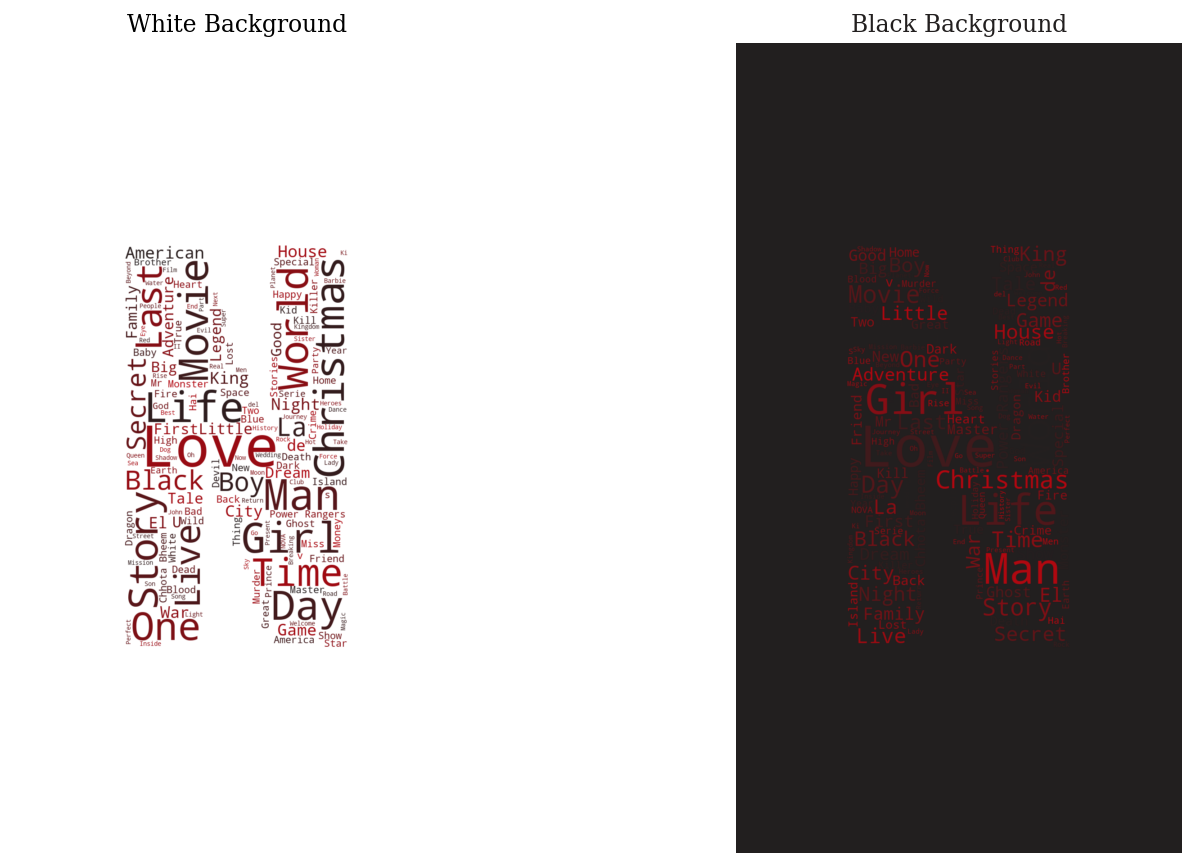

time: 6.12 s (started: 2024-07-12 18:50:31 +09:00)


In [33]:
# Custom color map based on Netflix palette
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#221f1f", "#b20710"])

# Combine all titles into a single string
text = ' '.join(df['title']).replace('.', '')

# Load the mask image
mask = np.array(Image.open('./Netflix_Symbol_RGB.png'))

# Generate the word clouds with different background colors
wordcloud_params = {
    'width': 500,
    'height': 200,
    'colormap': cmap,
    'max_words': 150,
    'mask': mask
}

wordcloud1 = WordCloud(background_color='white', **wordcloud_params).generate(text)
wordcloud2 = WordCloud(background_color='#221f1f', **wordcloud_params).generate(text)

# Display the word clouds
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(wordcloud1, interpolation='bilinear')
axes[0].axis('off')
axes[0].set_title('White Background', fontfamily='serif')

axes[1].imshow(wordcloud2, interpolation='bilinear')
axes[1].axis('off')
axes[1].set_title('Black Background', fontfamily='serif', color='#221f1f')

plt.tight_layout(pad=0)
plt.show()